# Clustering:
To partition a large state space, we need to partition it in a strucutered way to make it smaller. We can cluster(compress) similar features together in a local region of space and give them a label representing the region via some measure of distance known as a metric.

To partition a space one must define a boundary cutting the volume into regions.
  
![PAM](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/K-Medoids_Clustering.gif/600px-K-Medoids_Clustering.gif)

There are many clustering algorithms out there K-medoids is reminicent of the popular k-means 
algorithm and it supports of any distance metric.

## K-Medoids

https://en.wikipedia.org/wiki/K-medoids:
Both the k-means and k-medoids algorithms are partitional (breaking the dataset up into groups) and both attempt to minimize the distance between points labeled to be in a cluster and a point designated as the center of that cluster. In contrast to the k-means algorithm, k-medoids chooses data points as centers (medoids or exemplars) and can be used with arbitrary distances, while in k-means the centre of a cluster is not necessarily one of the input data points (it is the average between the points in the cluster).

# PAM

Algorithms

PAM choosing initial medoids, then iterating to convergence for k=3 clusters, visualized with ELKI. The most common realisation of k-medoid clustering is the partitioning around medoids (PAM) algorithm. PAM uses a greedy search which may not find the optimum solution, but it is faster than exhaustive search. 

It works as follows:
1. Initialize: greedily select k of the n data points as the medoids to minimize the cost
2. Associate each data point to the closest medoid.
3. While the cost of the configuration decreases:
  1. For each medoid m, and or each non-medoid data point o:
    1. Consider the swap of m and o, and compute the cost change
    2. If the cost change is the current best, remember this m and o combination
  2. Perform the best swap of m_best and o_best, if it decreases the cost function. Otherwise, the algorithm terminates.

In [1]:
#example clustering data
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.samples.definitions import SIMPLE_SAMPLES
# Useful data sets
# https://github.com/annoviko/pyclustering/blob/master/pyclustering/samples/definitions.py
# SAMPLE_TWO_DIAMONDS SAMPLE_WING_NUT #SAMPLE_TARGET
# SAMPLE_GOLF_BALL SAMPLE_TWO_DIAMONDS SAMPLE_ENGY_TIME

#math and performance
import numpy as np
from numba import njit, prange, jit

#distance metrics ######################

#vector metrics
@njit
def hammingVector(stack1, stack2):
    return (stack1 != stack2).sum(axis=1)
@njit
def euclideanVector(stack1, stack2):
    return (np.absolute(stack2-stack1)).sum(axis=1)

# point metrics
def euclideanPoint(p1, p2): 
    return np.sum((p1 - p2)**2) 
def hammingPoint(p1, p2): 
    return np.sum((p1 != p2)) 


In [2]:
def optimiseClusterMembership(data, n=4, metric=hammingVector, intitalClusterIndices=None): # data=visualFeatureVocabulary
    print("optimiseClusterMembership")
    if intitalClusterIndices is None:
        index = np.random.choice(data.shape[0], n, replace=False) 
    else:
        index = intitalClusterIndices
    centeroids = np.asarray([data[i] for i in index], dtype=data.dtype)
    centeroidVectors = [data]
    for centeroid in centeroids:
        centeroidColumn = np.zeros(shape=(data.shape[0],data.shape[1]), dtype=data.dtype)
        centeroidColumn[:,:] = centeroid
        centeroidVectors.append(centeroidColumn)
    stack = np.asarray(centeroidVectors, dtype=data.dtype)
    distances = []
    for i in range(n):
        distances.append(metric(stack[0], stack[i+1]))
    distances = np.asarray(distances, dtype=np.float32).T 
    closestClusterIndexVector = np.argmin(distances, axis=1)
    clusterInfo = []
    for i in range(n):
        cluster = (np.where(np.equal(closestClusterIndexVector, i))[0])
        cluster = np.delete(cluster, np.where(cluster==index[i]), 0)
        clusterInfo.append(cluster)
    clusteredPoints = []
    sumPoints = 0
    for i in range(n):
        clusteredPoints.append(clusterInfo[i])
        sumPoints = sumPoints + clusteredPoints[i].shape[0]
    assert sumPoints == data.shape[0] - n
    return (np.asarray([i for i in index], dtype=np.int64), clusteredPoints)


Optimising optimise

In [3]:
%%time
import torch
from numba import jit, prange
from torch.nn import functional as f

@jit(nopython=True) #,  parallel=True
def getPermutationCostAndBestSelection(cluster, data, metric=euclideanVector):
    lenCluster = len(cluster)
    print("getPermutationCostAndBestSelection", lenCluster)
    # old cluster value!!!
    bestCenteroidIndex = 0
    lastCost = -1.0
    sumCost = 0
    for clusterPointId in range(lenCluster):
            if ((100 * clusterPointId)/lenCluster) % 2 == 0:
                print("progress", clusterPointId/lenCluster)
            testCenteroid = cluster[clusterPointId]
            testCenteroidColumn = np.zeros(shape=(cluster.shape[0], data[testCenteroid].shape[0]), dtype=data[testCenteroid].dtype)
            testCenteroidColumn[:,:] = data[testCenteroid].reshape(1, data[testCenteroid].shape[0])  
            newClusterColumn = np.zeros(shape=(cluster.shape[0], data[testCenteroid].shape[0]), dtype=data.dtype)
            for i in range(0, lenCluster):
                newClusterColumn[i] = data[cluster[i]]
            pairwiseDistance = metric(newClusterColumn, testCenteroidColumn)
            cost = np.sum(pairwiseDistance)
            sumCost = sumCost + cost
            if (cost < lastCost or lastCost < 0):
                lastCost = cost
                bestCenteroidIndex = clusterPointId
    return (bestCenteroidIndex, sumCost)

def optimiseCentroidSelection(centeroids, clusters, data, metric=euclideanVector):
    print("optimiseCentroidSelection")
    #dataTensor = torch.tensor(data)
    newCenteroidIds = []
    newClusters = []
    totalCost = 0
    for clusterIdx in range(len(clusters)):
        print("clusterIdx", clusterIdx)
        # take current centeroid from the data
        oldCenteroid = centeroids[clusterIdx]
        # get cluster ids
        clusterIds = clusters[clusterIdx] #np.asarray()
        #add old centeroid into cluster stack
        fullStack = np.append(clusterIds, oldCenteroid)
        #get best choice and get cost of arrangement
        bestCenteroidClusterIndex, sumCost = getPermutationCostAndBestSelection(fullStack, data, metric)
        totalCost = totalCost + sumCost
        #add new centeroid to output
        newCenteroidIds.append(fullStack[bestCenteroidClusterIndex])
        # remove best centeroid from cluster
        bestCenteroidMask = np.where((fullStack==fullStack[bestCenteroidClusterIndex]))[0] #np.where(clusterIds==bestCenteroidClusterIndex)[0]
        clusterStackWithoutBestCenteroid = np.delete(fullStack, bestCenteroidMask, 0)
        # add old centeroid into cluster
        newClusterStack = np.append(oldCenteroid, clusterStackWithoutBestCenteroid)
        newClusters.append(newClusterStack)
    return (newCenteroidIds, newClusters, totalCost)
   

CPU times: user 187 ms, sys: 11.8 ms, total: 199 ms
Wall time: 199 ms


(770, 2)
optimiseClusterMembership
iteration
1
optimiseCentroidSelection
clusterIdx 0
getPermutationCostAndBestSelection 151
progress 0.0
clusterIdx 1
getPermutationCostAndBestSelection 55
progress 0.0
progress 0.2
progress 0.4
progress 0.6
progress 0.8
clusterIdx 2
getPermutationCostAndBestSelection 63
progress 0.0
clusterIdx 3
getPermutationCostAndBestSelection 13
progress 0.0
clusterIdx 4
getPermutationCostAndBestSelection 118
progress 0.0
progress 0.5
clusterIdx 5
getPermutationCostAndBestSelection 134
progress 0.0
progress 0.5
clusterIdx 6
getPermutationCostAndBestSelection 41
progress 0.0
clusterIdx 7
getPermutationCostAndBestSelection 94
progress 0.0
progress 0.5
clusterIdx 8
getPermutationCostAndBestSelection 101
progress 0.0
optimiseClusterMembership
(True, 73619.09863448143, inf, -inf)
cost improving...
73619.09863448143
--------------------
iteration
2
optimiseCentroidSelection
clusterIdx 0
getPermutationCostAndBestSelection 110
progress 0.0
progress 0.1
progress 0.2
progres

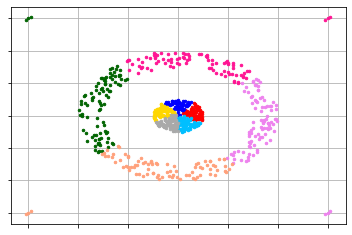

CPU times: user 3.74 s, sys: 47.9 ms, total: 3.79 s
Wall time: 3.77 s


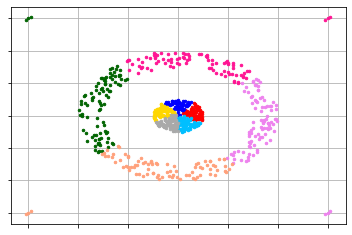

In [4]:
%%time

sample = read_sample(FCPS_SAMPLES.SAMPLE_TARGET) 
data = np.asarray(sample, dtype=np.float32)
regions = 9

print(data.shape)
# not perfect but we can use the cost to get the best local mininimum given a particular seed

lastCenteroids, lastClusters = optimiseClusterMembership(data, regions, euclideanVector)
lastCost = float('inf')

iteration = 0
escape = False
while not escape:
    iteration = iteration + 1
    print("iteration")
    print(iteration)
    currentCenteroids, currentClusters, currentCost = optimiseCentroidSelection(lastCenteroids, lastClusters, data, metric=euclideanVector)
    currentCenteroids, currentClusters = optimiseClusterMembership(data, regions, euclideanVector, currentCenteroids)
    print((currentCost<lastCost, currentCost, lastCost, currentCost - lastCost))
    if (currentCost<lastCost):
        print("cost improving...")
        print(currentCost)
        lastCost = currentCost
        lastCenteroids = currentCenteroids
        lastClusters = currentClusters
    else:
        print("cost got worse or did not improve")
        print(currentCost)
        print("resort to last config")
        escape = True
    print("--------------------")
print("last cost")
print(lastCost)

#centeroids, clusters = selectRandomClusters(data, regions, euclidean)
#centeroids, clusters, _ = optimise(centeroids, clusters, data, metric=euclidean)
#centeroids, clusters = selectRandomClusters(data, regions, euclidean, centeroids)
#centeroids, clusters ,_ = optimise(centeroids, clusters, data, metric=euclidean)
#centeroids, clusters = selectRandomClusters(data, regions, euclidean, centeroids)
#centeroids, clusters, _ = optimise(centeroids, clusters, data, metric=euclidean)
#centeroids, clusters = selectRandomClusters(data, regions, euclidean, centeroids)

visualizer = cluster_visualizer()
visualizer.append_clusters(lastClusters, sample)
visualizer.show()

It works, but the result with random seeding is wayyy to sensitive on inital centeroid choice, we dont always get a sensible result. Picking the seederoids with a heuristic would be better!

We will look at k++ for centeroid seeding

# KMeans++ Seeding

The exact algorithm is as follows:

1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard k-means clustering.

https://en.wikipedia.org/wiki/K-means%2B%2B

In [5]:
import sys

def seedClusters(data, k, distance=euclideanPoint): 
    print("seedClusters")
    ''' 
    Intialise the centroids for K-means++ 
    https://www.geeksforgeeks.org/ml-k-means-algorithm/
    '''
    ## initialize the centroids list and add 
    ## a randomly selected id to the list 
    centroids = list(np.random.choice(data.shape[0], 1, replace=False))
    ## compute remaining k - 1 centroids 
    for c_id in range(k - 1):
        print("c_id", c_id)
        dist = [] 
        for i in range(data.shape[0]): 
            point = data[i, :] 
            d = sys.maxsize 
            ## compute distance of 'point' from each of the previously 
            ## selected centroid and store the minimum distance 
            for j in range(len(centroids)): 
                temp_dist = distance(point, data[centroids[j]]) 
                d = min(d, temp_dist) 
            dist.append(d) 
        ## select data point with maximum distance as our next centroid 
        dist = np.array(dist) 
        next_centroid = np.argmax(dist) #data[np.argmax(dist), :] 
        centroids.append(next_centroid) 
        dist = [] 
    return centroids 
        

In [6]:
sample = read_sample(FCPS_SAMPLES.SAMPLE_TARGET) 
sampleData = np.asarray(sample, dtype=np.float32)
seedClusters(sampleData, 4, euclideanPoint)

seedClusters
c_id 0
c_id 1
c_id 2


[389, 766, 768, 767]

In [7]:
lastClusters = None
def clusterOpt(data, nRegions, pointMetric, vectorMetric):
    print("clusterOpt")
    # define a routine to keep going until cost stays the same or gets worse
    #get seeds
    seeds = seedClusters(data, nRegions, pointMetric)
    print(seeds)
    lastCenteroids, lastClusters = optimiseClusterMembership(data, nRegions, vectorMetric, seeds)
    lastCost = float('inf')
    iteration = 0
    escape = False
    while not escape:
        iteration = iteration + 1
        currentCenteroids, currentClusters, currentCost = optimiseCentroidSelection(lastCenteroids, np.asarray(lastClusters), data, vectorMetric)
        currentCenteroids, currentClusters = optimiseClusterMembership(data, nRegions, vectorMetric, list(currentCenteroids))
        print((currentCost<lastCost, currentCost, lastCost, currentCost - lastCost))
        if (currentCost<lastCost):
            print(("iteration",iteration,"cost improving...", currentCost, lastCost))
            lastCost = currentCost
            lastCenteroids = currentCenteroids
            lastClusters = currentClusters
        else:
            print(("iteration",iteration,"cost got worse or did not improve", currentCost, lastCost))
            escape = True
        print("--------------------")
    return (lastCenteroids, lastClusters)

clusterOpt
seedClusters
c_id 0
c_id 1
c_id 2
c_id 3
c_id 4
c_id 5
c_id 6
c_id 7
[640, 766, 768, 767, 511, 402, 483, 534, 65]
optimiseClusterMembership
optimiseCentroidSelection
clusterIdx 0
getPermutationCostAndBestSelection 92
progress 0.0
progress 0.5
clusterIdx 1
getPermutationCostAndBestSelection 3
progress 0.0
clusterIdx 2
getPermutationCostAndBestSelection 3
progress 0.0
clusterIdx 3
getPermutationCostAndBestSelection 3
progress 0.0
clusterIdx 4
getPermutationCostAndBestSelection 94
progress 0.0
progress 0.5
clusterIdx 5
getPermutationCostAndBestSelection 3
progress 0.0
clusterIdx 6
getPermutationCostAndBestSelection 87
progress 0.0
clusterIdx 7
getPermutationCostAndBestSelection 87
progress 0.0
clusterIdx 8
getPermutationCostAndBestSelection 398
progress 0.0
progress 0.5
optimiseClusterMembership
(True, 132823.52364349365, inf, -inf)
('iteration', 1, 'cost improving...', 132823.52364349365, inf)
--------------------
optimiseCentroidSelection
clusterIdx 0
getPermutationCostAndBes

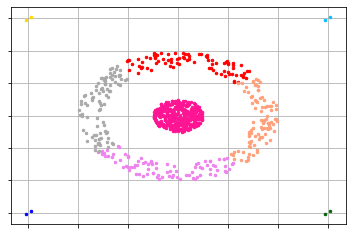

CPU times: user 1.9 s, sys: 12.1 ms, total: 1.91 s
Wall time: 1.91 s


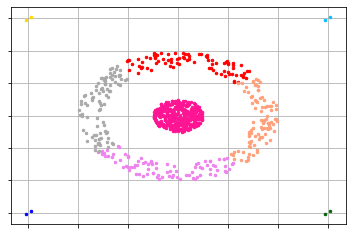

In [8]:
%%time
# More data sets
# https://github.com/annoviko/pyclustering/blob/master/pyclustering/samples/definitions.py
# SAMPLE_TWO_DIAMONDS SAMPLE_WING_NUT #SAMPLE_TARGET
# SAMPLE_GOLF_BALL SAMPLE_TWO_DIAMONDS SAMPLE_ENGY_TIME
sample = read_sample(FCPS_SAMPLES.SAMPLE_TARGET) 
sampleData = np.asarray(sample, dtype=np.float32)

visualizer = cluster_visualizer()
bestCentroids, bestClusters = clusterOpt(sampleData, regions, euclideanPoint, euclideanVector)
visualizer.append_clusters(bestClusters, sample)
visualizer.show()